In [1]:
from __future__ import print_function, division
import torch
import torch
import torch.nn as nn
import torch.optim as optim
import data as dt
import model_4 as md
import copy
from pytorch_ssim import ssim
from torch.utils.data import DataLoader

In [2]:
# print gpu
torch.cuda.set_device(4)
currentDevice = torch.cuda.current_device()
print("Current GPU: " + str(currentDevice))
print(str(torch.cuda.device_count()))
print(str(torch.cuda.get_device_capability(currentDevice)))
print(torch.__version__)

Current GPU: 4
8
(6, 1)
1.0.0


In [3]:
USE_GPU = 1
if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda:4')
else:
    device = "cpu"
print(device)

cuda:4


In [ ]:
# generate csv file, run only for the first time
# dt.generate_csv()

In [4]:
csvFilePath = dt.get_csv_path()
transformed_dataset = dt.HE_SHG_Dataset(csv_file=csvFilePath,
                                               transform=dt.Compose([                                              
                                               dt.Rescale(96),                                     
                                               dt.Normalize(),
                                               dt.ToTensor()
                                           ]))
# TODO: change the normalization parameters

In [7]:
# batchsize 32->16
dataloader = DataLoader(transformed_dataset, batch_size=50,
                        shuffle=True, num_workers=0)

0 torch.Size([50, 3, 96, 96]) torch.Size([50, 96, 96])
1 torch.Size([50, 3, 96, 96]) torch.Size([50, 96, 96])
2 torch.Size([50, 3, 96, 96]) torch.Size([50, 96, 96])
3 torch.Size([50, 3, 96, 96]) torch.Size([50, 96, 96])
torch.Size([50, 1, 96, 96])


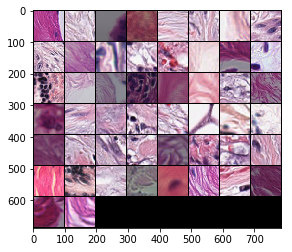

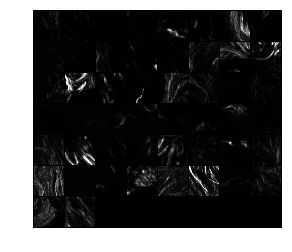

In [8]:
# TODO: insert back mean and variance to plot the image appropriately
dt.show_patch(dataloader) 

In [12]:
print('===> Building model')
model = md.Net().to(device)
criterionMSE = nn.MSELoss()

optimizer = optim.Adam(model.parameters(), lr=0.001)


===> Building model


In [13]:
def train(epoch):
    epoch_loss = 0
    for iteration, batch in enumerate(dataloader):
        input, target = batch['input'].to(device), batch['output'].to(device)

        optimizer.zero_grad()
        output = model(input)
        targetf = target.float()
        targetf = targetf[:, None]
        
        lossMSE = criterionMSE(output, targetf)      
        lossSSIM = -(ssim(output, targetf)-1)
        
        p = 0.75
        loss = p*lossMSE + (1-p)*lossSSIM
        combineLoss = p*lossMSE.item() + (1-p)*lossSSIM.item()
        
        epoch_loss = epoch_loss + combineLoss
        loss.backward()
        optimizer.step()
    
        if iteration%50 == 0:
            print("lossMSE: " + str(lossMSE.item()) +
                  " " + "lossSSIM: " + str(lossSSIM.item()))
            print("===> Epoch[{}]({}/{}): Loss: {:.4f}".format(epoch, iteration, len(dataloader), loss.item()))

    print("===> Epoch {} Complete: Avg. Loss: {:.4f}".format(epoch, epoch_loss / len(dataloader)))


In [ ]:
# def test():
#     avg_psnr = 0
#     with torch.no_grad():
#         for batch in testing_data_loader:
#             input, target = batch[0].to(device), batch[1].to(device)

#             prediction = model(input)
#             mse = criterion(prediction, target)
#             psnr = 10 * log10(1 / mse.item())
#             avg_psnr += psnr
#     print("===> Avg. PSNR: {:.4f} dB".format(avg_psnr / len(testing_data_loader)))


In [ ]:
# def checkpoint(epoch):
#     model_out_path = "model_epoch_{}.pth".format(epoch)
#     torch.save(model, model_out_path)
#     print("Checkpoint saved to {}".format(model_out_path))

In [ ]:
for epoch in range(1, 10 + 1):
    train(epoch)
#     test()
#     checkpoint(epoch)

lossMSE: 0.2686838209629059 lossSSIM: 0.9838903546333313
===> Epoch[1](0/16220): Loss: 0.4475
lossMSE: 0.22525112330913544 lossSSIM: 0.949894368648529
===> Epoch[1](50/16220): Loss: 0.4064


In [13]:
import matplotlib.pyplot as plt
from torchvision import transforms, utils
def test():
    avg_psnr = 0
    with torch.no_grad():
        for iteration, batch in enumerate(dataloader):
            input, target = batch['input'].to(device), batch['output'].to(device)
                
            prediction = model(input)

            target = target.float()

            outdataloader = {'input':prediction,'output':target}
            
            print(outdataloader['input'].size(), 
                      outdataloader['output'].size())

            plt.figure()
            input_batch, label_batch = outdataloader['input'], outdataloader['output']
            batch_size = 100
            im_size = input_batch.size(2)
            label_batch=label_batch.reshape([batch_size,1,im_size,im_size])
            print(label_batch.size())
            for img in input_batch:
                for t, m, s in zip(img, [0.5, 0.5, 0.5], [0.5, 0.5, 0.5]):
                    t.mul_(s).add_(m)
                            
            for img in label_batch:
                for t, m, s in zip(img, [0.5, 0.5, 0.5], [0.5, 0.5, 0.5]):
                    t.mul_(s).add_(m)                           

            grid = utils.make_grid(input_batch).cpu()
            plt.imshow(grid.numpy().transpose((1, 2, 0)))
            plt.figure()

            grid = utils.make_grid(label_batch).cpu()
            plt.imshow(grid.numpy().transpose((1, 2, 0)))

            plt.axis('off')
            plt.ioff()
            plt.show()
            
            targetf = target[:, None]
            
            lossMSE = criterionMSE(prediction, targetf)      
            lossSSIM = -ssim(prediction, targetf)
        
            p = 0.25
            loss = p*lossMSE + (1-p)*lossSSIM
            combineLoss = p*lossMSE.item() + (1-p)*lossSSIM.item()
#             mse = criterion(prediction, target.float())

            psnr = 10 * torch.log10(1 / loss)
            avg_psnr += psnr
            if iteration == 16:
                break
    print("===> Avg. PSNR: {:.4f} dB".format(avg_psnr / len(dataloader)))

torch.Size([100, 1, 96, 96]) torch.Size([100, 96, 96])
torch.Size([100, 1, 96, 96])


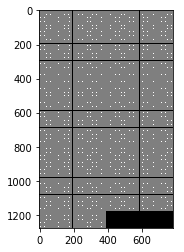

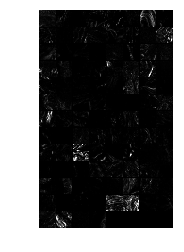

torch.Size([100, 1, 96, 96]) torch.Size([100, 96, 96])
torch.Size([100, 1, 96, 96])


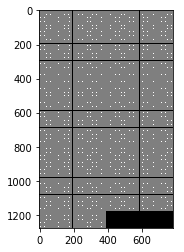

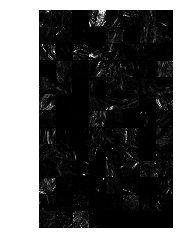

torch.Size([100, 1, 96, 96]) torch.Size([100, 96, 96])
torch.Size([100, 1, 96, 96])


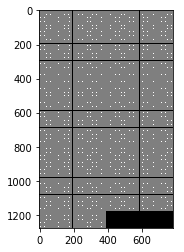

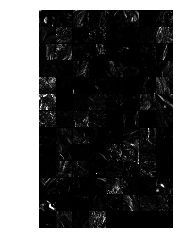

torch.Size([100, 1, 96, 96]) torch.Size([100, 96, 96])
torch.Size([100, 1, 96, 96])


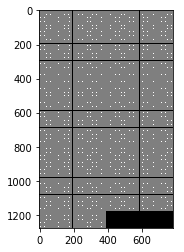

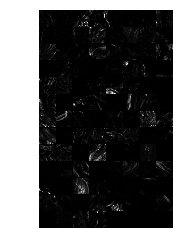

torch.Size([100, 1, 96, 96]) torch.Size([100, 96, 96])
torch.Size([100, 1, 96, 96])


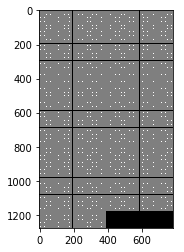

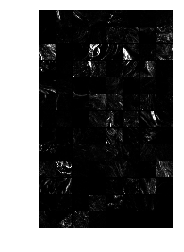

torch.Size([100, 1, 96, 96]) torch.Size([100, 96, 96])
torch.Size([100, 1, 96, 96])


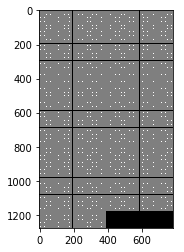

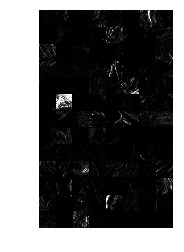

torch.Size([100, 1, 96, 96]) torch.Size([100, 96, 96])
torch.Size([100, 1, 96, 96])


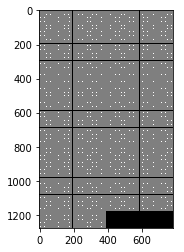

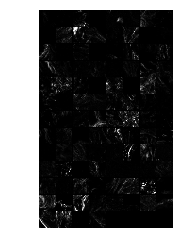

torch.Size([100, 1, 96, 96]) torch.Size([100, 96, 96])
torch.Size([100, 1, 96, 96])


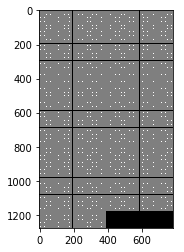

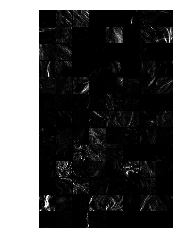

torch.Size([100, 1, 96, 96]) torch.Size([100, 96, 96])
torch.Size([100, 1, 96, 96])


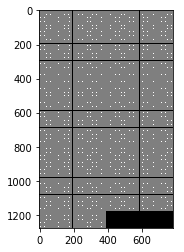

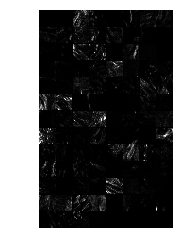

torch.Size([100, 1, 96, 96]) torch.Size([100, 96, 96])
torch.Size([100, 1, 96, 96])


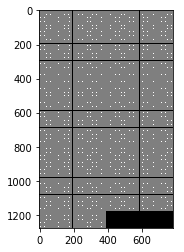

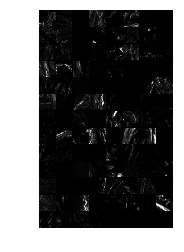

torch.Size([100, 1, 96, 96]) torch.Size([100, 96, 96])
torch.Size([100, 1, 96, 96])


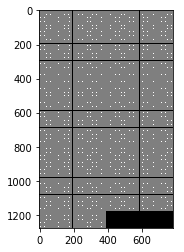

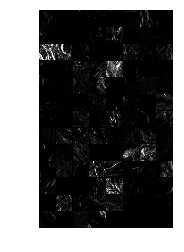

torch.Size([100, 1, 96, 96]) torch.Size([100, 96, 96])
torch.Size([100, 1, 96, 96])


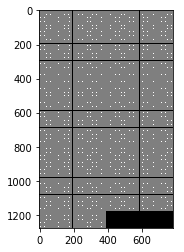

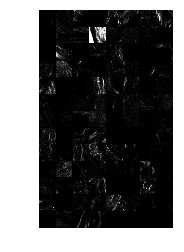

torch.Size([100, 1, 96, 96]) torch.Size([100, 96, 96])
torch.Size([100, 1, 96, 96])


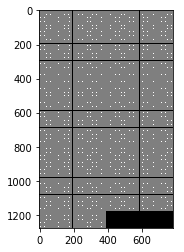

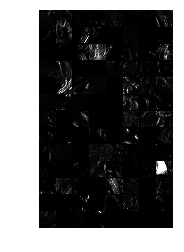

torch.Size([100, 1, 96, 96]) torch.Size([100, 96, 96])
torch.Size([100, 1, 96, 96])


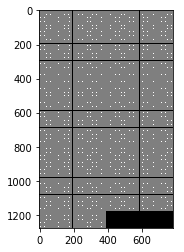

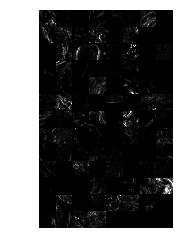

torch.Size([100, 1, 96, 96]) torch.Size([100, 96, 96])
torch.Size([100, 1, 96, 96])


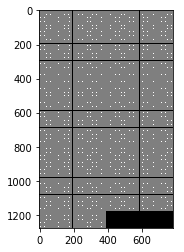

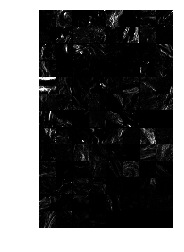

torch.Size([100, 1, 96, 96]) torch.Size([100, 96, 96])
torch.Size([100, 1, 96, 96])


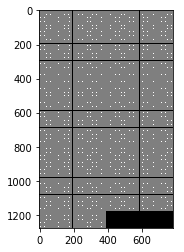

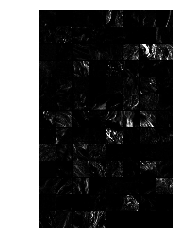

torch.Size([100, 1, 96, 96]) torch.Size([100, 96, 96])
torch.Size([100, 1, 96, 96])


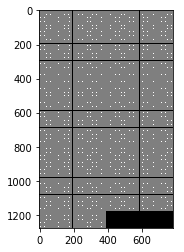

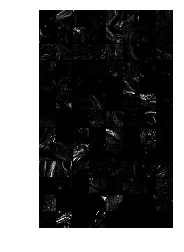

===> Avg. PSNR: 0.0270 dB


In [14]:
test()

In [ ]:
# restart
for epoch in range(1, 5 + 1):
    train(epoch)
#     test()
#     checkpoint(epoch)